## Summary

I tested the prediction of user-adoption using a random forest classifier against the accuracy using a Naïve Bayes model that predicted user adoption in 100% of cases. The machine learning model (accuracy of 0.85) did not show an improvement over the Naive Bayes model (accuracy of 0.87). No individual variables appear to be strongly predictive.

I processed the data to create a list of “adopted users” by looping through the usage summary table ("takehome_user_engagement") for each unique user it contained using the Pandas “rolling” method and finding the maximum number of visits that occurred for them in a 7-day window. Three or greater visits received a “1” in a new “adopted_status” column. This was then merged with the rest of the user data.

A significant training variable that I dropped from the from the takehome_users.csv file was last_session_creation_time, which is the timestamp of the user’s last login. An active user would have a higher frequency of logins and be more likely to have a recent last_session time, but the outcome variable is defined solely by the frequency of logins in a 7-day window. So, this would be a form of the outcome leaking into the training data.

I looked briefly at engineering a feature for "top influencers", but most user ids have a relatively small amount of referrals. An alternate approach that could be explored is to change the criteria for an "adopted user". Instead of making it a binary classification of adopted vs non-adopted users, the outcome could be the maximum density of logins for each user ID within a 30-day window, and then analyzed as a regression problem.


In [1]:
import numpy as np
import pandas as pd

import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

## Data Cleaning

In [2]:
users = pd.read_csv('takehome_users.csv')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
visits = pd.read_csv('takehome_user_engagement.csv')
visits.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
print(len(visits))
print(len(visits['time_stamp'].unique()))

207917
207220


There are some identical timestamps so they need to be made unique to work as an index. Add very small random number to datetime and then sort. Index needs to be datetime for pandas rolling function.

In [5]:
# Convert to datetime
visits['time_stamp'] = pd.to_datetime(visits['time_stamp'])

# Make datetimes unique
visits['timedelta'] = np.random.uniform(0,.01)
visits['timedelta'] = pd.to_timedelta(visits['timedelta'])
visits['adj_time'] = visits['time_stamp'] + visits['timedelta']

In [6]:
# Sort in ascending time
visits.sort_values('adj_time', ascending=True, inplace=True)

In [7]:
# Reset the index using the unique timestamps
visits.set_index('adj_time', inplace=True)

In [8]:
visits.tail()

,time_stamp,user_id,visited,timedelta
adj_time,,,,
2014-06-04 23:32:13,2014-06-04 23:32:13,4625,1,0 days
2014-06-04 23:34:04,2014-06-04 23:34:04,9325,1,0 days
2014-06-04 23:46:31,2014-06-04 23:46:31,9558,1,0 days
2014-06-04 23:56:26,2014-06-04 23:56:26,341,1,0 days
2014-06-06 14:58:50,2014-06-06 14:58:50,4051,1,0 days


Check to make sure each row in the dataframe is a visit on a unique day for a unique user

In [9]:
print(len(visits))

visits['visit_date'] = visits['time_stamp'].dt.date
print(len(visits.groupby(['user_id','visit_date']).count()))

207917
207917


Determine which users logged in during 3 unique days within a 7 day period:

In [10]:
# Start empty lists to append values to as the pandas "rolling" function assesses 7-day periods 
user_id = []
max_rolling_visits = []

In [11]:
for user in tqdm(visits['user_id'].unique()):
    user_id.append(user)
    max_rolling_visits.append(visits[visits['user_id'] == user].rolling('7d').sum()['visited'].max())

100%|██████████| 8823/8823 [00:10<00:00, 837.45it/s]


In [12]:
adopted_status = pd.DataFrame({'user_id': user_id, 'max_7day_window': max_rolling_visits})
adopted_status.head()

,user_id,max_7day_window
0,10012,1.0
1,3428,2.0
2,9899,1.0
3,1693,7.0
4,6102,1.0


In [13]:
# visually inspect an example user to check if 7-day max is accurate; looks okay
visits[visits['user_id'] == 3428]

,time_stamp,user_id,visited,timedelta,visit_date
adj_time,,,,,
2012-05-31 15:47:36,2012-05-31 15:47:36,3428,1,0 days,2012-05-31
2012-06-08 15:47:36,2012-06-08 15:47:36,3428,1,0 days,2012-06-08
2012-07-07 15:47:36,2012-07-07 15:47:36,3428,1,0 days,2012-07-07
2012-07-22 15:47:36,2012-07-22 15:47:36,3428,1,0 days,2012-07-22
2012-07-31 15:47:36,2012-07-31 15:47:36,3428,1,0 days,2012-07-31
2012-08-27 15:47:36,2012-08-27 15:47:36,3428,1,0 days,2012-08-27
2012-08-28 15:47:36,2012-08-28 15:47:36,3428,1,0 days,2012-08-28
2012-09-03 15:47:36,2012-09-03 15:47:36,3428,1,0 days,2012-09-03
2012-09-26 15:47:36,2012-09-26 15:47:36,3428,1,0 days,2012-09-26


In [14]:
adopted_status['adopted_user'] = (adopted_status['max_7day_window'] >= 3).astype(int)

In [15]:
# Merge the adopted user status into the main dataframe

df = pd.merge(users, adopted_status[['user_id','adopted_user']], how='left', left_on='object_id', right_on='user_id')
df.drop('user_id', axis=1, inplace=True)

In [16]:
# Check if all of the users from the users data frame show up in the visits dataframe
print(len(visits['user_id'].unique()))
print(len(users['object_id'].unique()))

8823
12000


There are more user IDs in the takehome_users dataset than there are in the visits dataset. This most likely means that these users did not login during the timeframe of data collection and they should not be considered adopted users. Zero fill missing values.

In [17]:
df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  3177
dtype: int64

In [18]:
df['adopted_user'].fillna(0, inplace=True)

## Pre-Processing

In [19]:
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                  float64
dtype: object

In [20]:
# Drop user_id, name, and email since they aren't expected to be predictive and would have many dummy variables
df.drop(['object_id', 'name', 'email'], axis=1, inplace=True)

- Drop last_session_creation_time; data on the users login patterns are what determine whether they are adopted user, so keeping this in would blur the line between input and target variables. 
- I am keeping creation_time because early users might be more excited about the product and more likely to become adopted users.

In [21]:
# Drop datetime data described above
df.drop(['last_session_creation_time'], axis=1, inplace=True)

In [22]:
# Create dummy variable for 'creation_source'
one_hot = pd.get_dummies(df['creation_source'])
df.drop('creation_source', axis=1, inplace=True)
df = df.join(one_hot)

In [23]:
# Zero-fill NaN values in "invited_by_user_id" column
df['invited_by_user_id'].fillna(0, inplace=True)

In [24]:
df.head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1,0,0,0,0
1,2013-11-15 03:45:04,0,0,1,316.0,1.0,0,1,0,0,0
2,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0,1,0,0,0
3,2013-05-21 08:09:28,0,0,1,5151.0,0.0,1,0,0,0,0
4,2013-01-17 10:14:20,0,0,193,5240.0,0.0,1,0,0,0,0


## Modeling

In [25]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user'].astype(int)

In [26]:
# Sklearn does not accept datetime formats; convert creation time back into ordinal
X['creation_time'] = pd.to_datetime(df['creation_time'])
X['creation_time'] = X['creation_time'].map(datetime.datetime.toordinal)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)

In [28]:
# Import model
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
model.fit(X_train, y_train);

y_pred = model.predict(X_test)

model.score(X_test, y_test)

0.8511111111111112

In [29]:
model.predict_proba(X)

array([[0.97, 0.03],
       [0.36, 0.64],
       [0.65, 0.35],
       ...,
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.97, 0.03]])

Visualize a decision tree from the random forest. creation_time, org_ID, and invited_user_id create too many branches to visualize, so omit them in the model for visualization purposes.

In [30]:
# Drop features with a high number of values for visualization purposes
X2 = df.drop(['creation_time', 'invited_by_user_id', 'org_id', 'adopted_user'], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state = 42)

# Instantiate model with 100 decision trees
vizmodel = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
vizmodel.fit(X_train2, y_train2);

y_pred2 = vizmodel.predict(X_test2)

vizmodel.score(X_test2, y_test2)

0.865

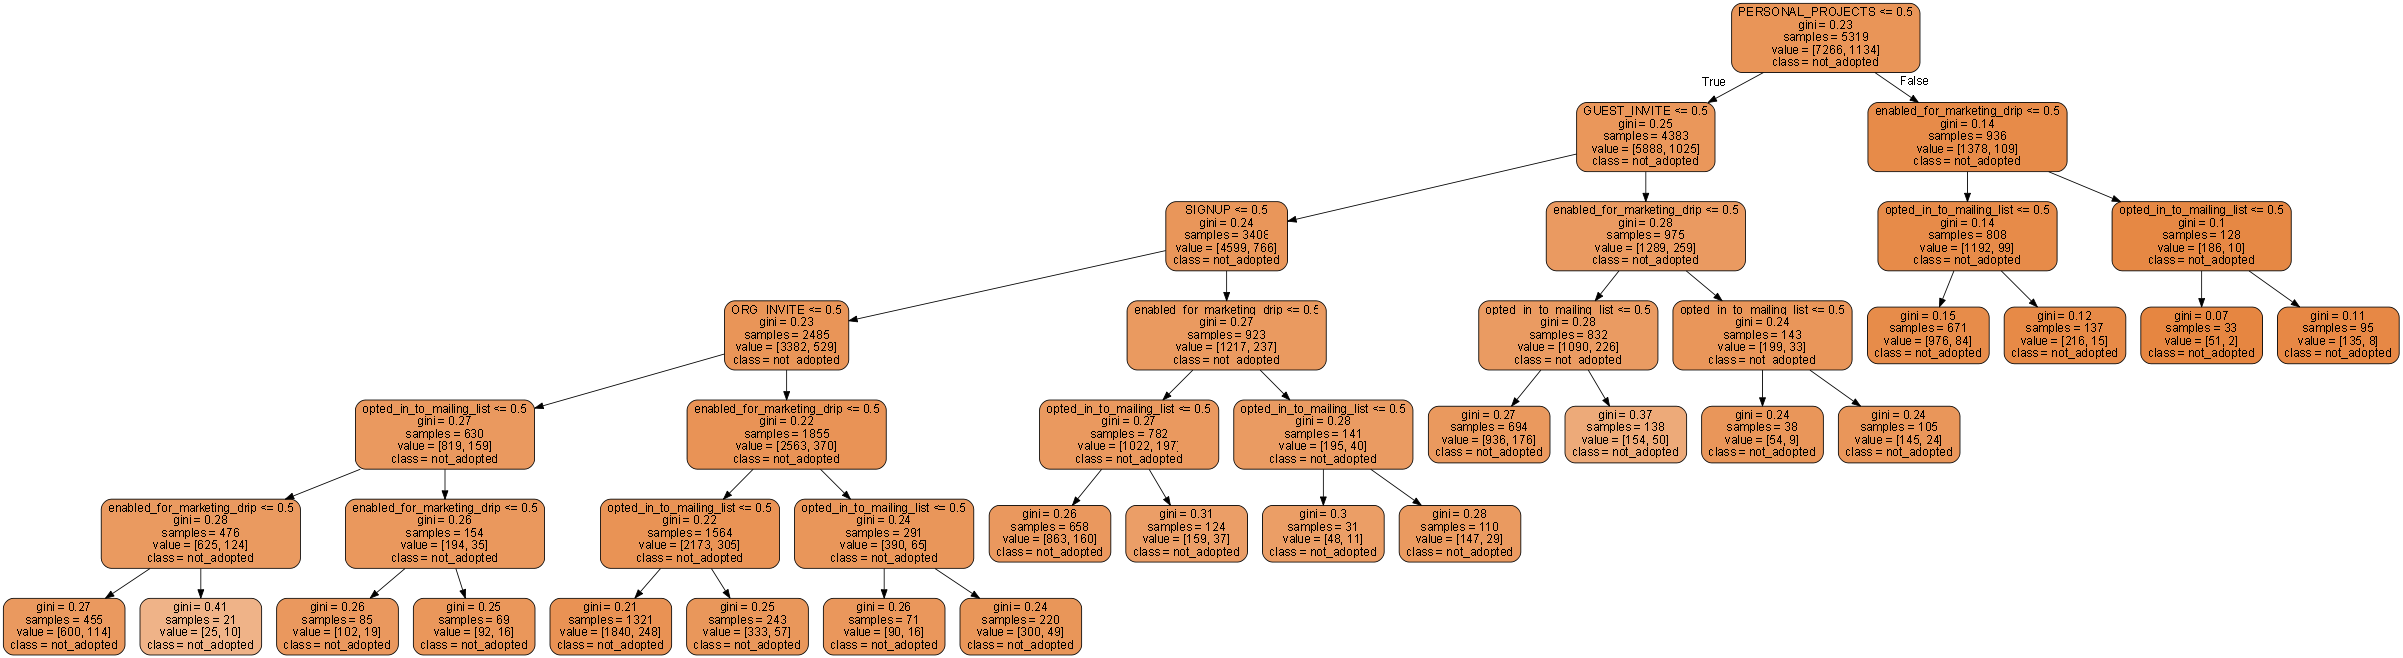

In [31]:
# Extract single tree
estimator = vizmodel.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X2.columns),
                class_names = ['not_adopted', 'adopted'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=60'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

<Figure size 432x288 with 0 Axes>

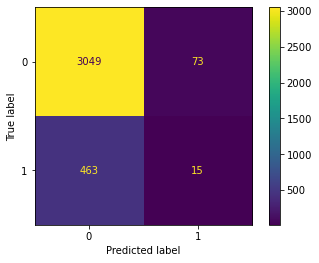

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

model_cm = confusion_matrix(y_true=y_pred, y_pred=y_pred)

plt.figure()
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [33]:
# Check accuracy
(3049+15)/len(y_test)

0.8511111111111112

Check naive bayes accuracy on test set.

In [34]:
# Fraction of adopted users
percent_adopted = sum(y_test)/len(y_test)
percent_adopted

0.13277777777777777

In [35]:
# Naive bayes for test set
sum(y_test==0)/len(y_test)

0.8672222222222222

Check naive bayes accuracy on whole dataset.

In [36]:
total_adopted = len(df[df['adopted_user']==0])

In [37]:
total_users = len(df)

In [38]:
total_adopted/total_users

0.8665

In [39]:
# Investigate result; are any variables correlated with the outcome?
X.corrwith(y)

creation_time                -0.088008
opted_in_to_mailing_list      0.008097
enabled_for_marketing_drip    0.004653
org_id                        0.064523
invited_by_user_id            0.021596
GUEST_INVITE                  0.045408
ORG_INVITE                   -0.007636
PERSONAL_PROJECTS            -0.075817
SIGNUP                        0.009299
SIGNUP_GOOGLE_AUTH            0.036119
dtype: float64

No variables are strongly correlated; check if maybe a new feature such as the number of people a user_id referred results in more adopted users.

In [40]:
# Get number of invitation counts for each user ID
invitation_counts = df.groupby('invited_by_user_id').count()
invitation_counts = invitation_counts[invitation_counts['creation_time'] >= 1]
invitation_counts.sort_values(by='adopted_user', ascending=False).head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
invited_by_user_id,,,,,,,,,,
0.0,5583,5583,5583,5583,5583,5583,5583,5583,5583,5583
10741.0,13,13,13,13,13,13,13,13,13,13
2527.0,12,12,12,12,12,12,12,12,12,12
1525.0,11,11,11,11,11,11,11,11,11,11
11770.0,11,11,11,11,11,11,11,11,11,11


In [41]:
# Drop invited_by_user_id = 0 because that ID is used as a missing value
invitation_counts.drop(0, axis=0, inplace=True)

In [42]:
means = df.groupby('invited_by_user_id').mean()
means.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
invited_by_user_id,,,,,,,,,
0.0,0.246283,0.148486,144.337274,0.12341,0.0,0.0,0.378112,0.373813,0.248075
3.0,0.000000,0.000000,94.000000,0.00000,0.0,1.0,0.000000,0.000000,0.000000
7.0,0.400000,0.400000,37.000000,0.00000,0.2,0.8,0.000000,0.000000,0.000000
10.0,0.000000,0.000000,318.000000,0.00000,1.0,0.0,0.000000,0.000000,0.000000
21.0,1.000000,0.000000,54.000000,0.00000,0.0,1.0,0.000000,0.000000,0.000000


In [43]:
influencers = pd.merge(means[['adopted_user']], invitation_counts[['creation_time']],  how='inner', left_index=True, right_index=True)
influencers.columns = ['adopted_user', 'number_of_referrals']


<AxesSubplot:xlabel='number_of_referrals', ylabel='adopted_user'>

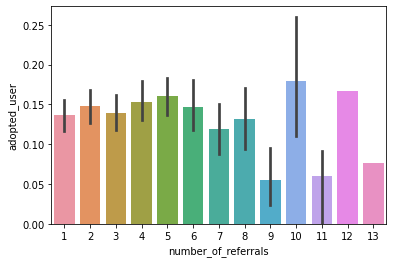

In [45]:
import seaborn as sns
sns.barplot(x=influencers['number_of_referrals'], y=influencers['adopted_user'])

Look at top influencers individually; consider "top influencer" >= 8 referrals.

In [46]:
top_influencers = influencers[influencers['number_of_referrals'] >= 8]
top_influencers.sort_values(by='adopted_user', ascending=False, inplace=True)

C:\Users\bradp\anaconda3\envs\Take_Home\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='invited_by_user_id', ylabel='adopted_user'>

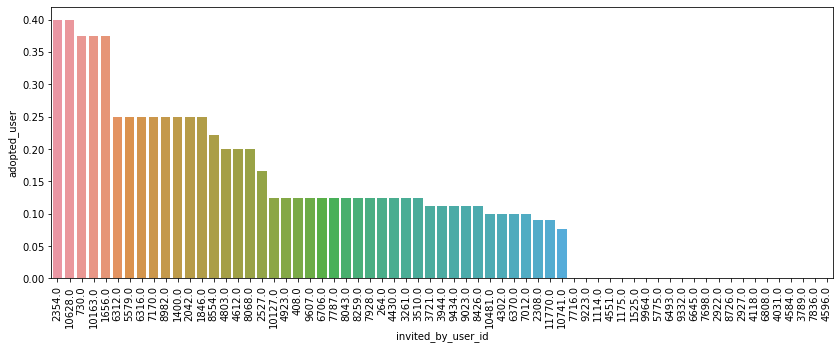

In [47]:
plt.figure(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x=top_influencers.index, y=top_influencers.adopted_user, order=list(top_influencers.index))